In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.visualization import MinMaxInterval, AsinhStretch, ImageNormalize
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
sys.path.insert(0, '../../../scripts/dc2')
import verification_utils as utils
from astropy.cosmology import wCDM, WMAP7
import lenstronomy.Util.param_util as param_util
from lenstronomy.Analysis.td_cosmography import TDCosmography
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from baobab.sim_utils import generate_image_simple
%matplotlib inline
%load_ext autoreload
%autoreload 2

Lenstronomy path being used: /home/jwp/stage/sl/lenstronomy/lenstronomy


# Verification of lensed AGN and host in DC2

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 2/20/2020

__Last run:__ 5/01/2020

We independently render images of lensed AGN and host components (bulge, disk) of DC2 strong lens systems using external software called Lenstronomy and Baobab, as a verification of the DC2 pipeline written by Nan Li and Matt Wiesner.

Reproducing OM10 with Lenstronomy not only verifies the images of lensed host components, but also gives us license to use the Lenstronomy-generated images, magnifications, and time delays in the case that we want to vary the inputs such as lens and source redshifts.

First dump the lens, AGN, and host truth tables as csv files in the containing `input_dir`.

In [5]:
input_dir = '../../../data/example_truth_050120'
utils.to_csv(os.path.join(input_dir, 'lens_truth.db'), input_dir)
utils.to_csv(os.path.join(input_dir, 'lensed_agn_truth.db'), input_dir)
utils.to_csv(os.path.join(input_dir, 'host_truth.db'), input_dir)

In [6]:
sys_id = 69712010 #4077543 # lens system ID
pixel_scale = 0.01 # arcsec/pix
num_pix = 1000
# Basic models
null_psf = utils.get_null_psf(pixel_scale) # delta function PSF
data_api = utils.get_data_api(pixel_scale, num_pix) # simulation tool for generating images
# Truth catalogs
src_light_df = pd.read_csv(os.path.join(input_dir, 'agn_hosts.csv'), index_col=None)
lens_df = pd.read_csv(os.path.join(input_dir, 'agn_lens.csv'), index_col=None)

In [8]:
from astropy.io import fits

om10_path = os.path.join(input_dir, 'om10_qso_mock.fits')
om10 = fits.open(om10_path)[1].data
col_names = ['LENSID', 'ELLIP', 'PHIE', 'GAMMA', 'PHIG', 'ZLENS', 'ZSRC', 'VELDISP', 'XSRC', 'YSRC', 'NIMG',]
df_data = {}
for col in col_names:
    df_data[col] = om10[col].byteswap().newbyteorder()
df_data['x_image'] = om10['XIMG'].tolist()
df_data['y_image'] = om10['YIMG'].tolist()
df_data['time_delays'] = om10['DELAY'].tolist()
om10_df = pd.DataFrame(df_data)
om10_df = om10_df[om10_df['LENSID'] == sys_id].T.squeeze()

We apply basic unit conversions common across all systems, for convenience.

In [9]:
# SIE lens mass
lens_phie_rad = np.pi*(lens_df['phie_lens']/180.0) + 0.5*np.pi # in rad, origin at y axis
lens_e1, lens_e2 = param_util.phi_q2_ellipticity(lens_phie_rad, 1 - lens_df['ellip_lens'])
lens_df['e1_lens'] = lens_e1
lens_df['e2_lens'] = lens_e2
# External shear
lens_df['phig_rad_lenscat'] = np.deg2rad(lens_df['phig_lenscat'])
# Sersic host light
src_light_df['position_angle_rad'] = 0.5*np.deg2rad(src_light_df['position_angle'])

# 1. Image of lensed bulge only

In [13]:
src_light_info = src_light_df.loc[src_light_df['lens_cat_sys_id']==sys_id].iloc[0].squeeze() # arbitarily take the first lensed image, since the source properties are the same between the images
lens_info = lens_df.loc[lens_df['lens_cat_sys_id']==sys_id].squeeze()
z_lens = om10_df['ZLENS'] #lens_info['redshift'] #
z_src = src_light_info['redshift']

components = ['lens_mass', 'external_shear', 'src_light',]
# Instantiate density models
#om10_cosmo = WMAP7 #
om10_cosmo = wCDM(H0=72.0, Om0=0.26, Ode0=0.74, w0=-1.0)
lens_mass_model = LensModel(['SIE', 'SHEAR_GAMMA_PSI',], cosmo=om10_cosmo, z_lens=z_lens, z_source=z_src)
src_light_model = LightModel(['CORE_SERSIC'])
lens_eq_solver = LensEquationSolver(lens_mass_model)

bulge_or_disk = 'bulge'
all_kwargs = {}
all_kwargs['lens_mass'] = utils.get_lens_params(lens_info, z_src=z_src, cosmo=om10_cosmo)
all_kwargs['external_shear'] = utils.get_external_shear_params(lens_info)
all_kwargs['src_light'] = utils.get_src_light_params(src_light_info, bulge_or_disk=bulge_or_disk)

Lenstronomy path being used: /home/jwp/stage/sl/lenstronomy/lenstronomy


In [14]:
# Generate the image
bulge_img, bulge_img_features = generate_image_simple(all_kwargs, null_psf, data_api, lens_mass_model, src_light_model, lens_eq_solver, pixel_scale, num_pix, components,  {'supersampling_factor': 1}, min_magnification=0.0, lens_light_model=None, ps_model=None,)
bulge_img /= np.max(bulge_img)

In [15]:
lens_info

index                      994
unique_id           2568481334
ra_lens                53.3887
dec_lens              -28.0516
redshift                  1.49
shear_1_cosmodc2   -0.00174271
shear_2_cosmodc2    0.00758986
kappa_cosmodc2      0.00781643
gamma_lenscat        0.0901368
phig_lenscat           63.3245
shear_1_lenscat      0.0498067
shear_2_lenscat      0.0751261
sindex_lens                  4
major_axis_lens      0.0509751
minor_axis_lens      0.0393788
position_angle         77.2118
ellip_cosmodc2        0.227489
ellip_lens            0.448853
phie_cosmodc2         -51.3941
phie_lens               79.884
av_mw                0.0225635
rv_mw                      3.1
vel_disp_lenscat       231.358
lens_cat_sys_id       69712010
dc2_sys_id           GLAGN_994
e1_lens               0.271514
e2_lens               -0.10007
phig_rad_lenscat       1.10522
Name: 994, dtype: object

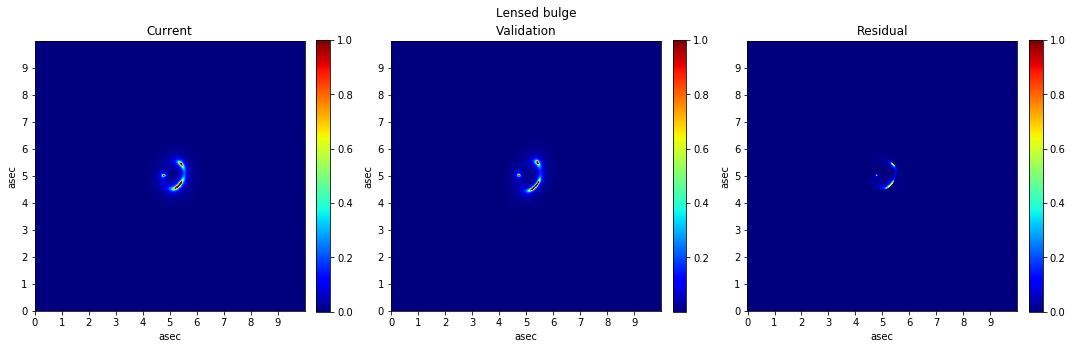

In [16]:
GLAGN_idx = int(lens_info['index'])
existing_bulge_img_path = '/home/jwp/stage/sl/LatestSLSprinkler/outputs/agn_lensed_bulges/GLAGN_host_{:d}_0_bulge.fits'.format(GLAGN_idx)
bulge_img_file = get_pkg_data_filename(existing_bulge_img_path)
orig_bulge_img_arr = fits.getdata(bulge_img_file, ext=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('Lensed bulge')
ticks = np.arange(0, 1000, 100)
tick_labels = np.arange(10)

norm = ImageNormalize(orig_bulge_img_arr, stretch=AsinhStretch())

axes[0].set_title('Current')
orig_img = axes[0].imshow(orig_bulge_img_arr.T, origin='lower', cmap='jet')
axes[0].set_xlabel('asec')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(tick_labels)
axes[0].set_ylabel('asec')
axes[0].set_yticks(ticks)
axes[0].set_yticklabels(tick_labels)
fig.colorbar(orig_img, ax=axes[0], fraction=0.046, pad=0.04)

axes[1].set_title('Validation')
val_img = axes[1].imshow(bulge_img, origin='lower',  cmap='jet')
axes[1].set_xlabel('asec')
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(tick_labels)
axes[1].set_ylabel('asec')
axes[1].set_yticks(ticks)
axes[1].set_yticklabels(tick_labels)
fig.colorbar(val_img, ax=axes[1], fraction=0.046, pad=0.04)

axes[2].set_title('Residual')
val_agn_img = axes[2].imshow(orig_bulge_img_arr.T - bulge_img, origin='lower', vmin=0, vmax=1, cmap='jet')
axes[2].set_xlabel('asec')
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(tick_labels)
axes[2].set_ylabel('asec')
axes[2].set_yticks(ticks)
axes[2].set_yticklabels(tick_labels)
fig.colorbar(val_agn_img, ax=axes[2], fraction=0.046, pad=0.04)

fig.tight_layout()

# 2. Image of lensed disk only

In [17]:
bulge_or_disk = 'disk'
all_kwargs['src_light'] = utils.get_src_light_params(src_light_info, bulge_or_disk=bulge_or_disk)

# Generate the image
disk_img, disk_img_features = generate_image_simple(all_kwargs, null_psf, data_api, lens_mass_model, src_light_model, lens_eq_solver, pixel_scale, num_pix, components,  {'supersampling_factor': 1}, min_magnification=0.0, lens_light_model=None, ps_model=None,)
disk_img /= np.max(disk_img)

# 3. Image positions

We'd also like to compare the OM10 image positions. To zeroth order, the OM10 image positions should fall at the center of the lensed host images. Both the current and verification images satisfy this requirement.

In [18]:
# Taken from OM10; Bryce will add this info to the truth catalog soon.
n_image = om10_df['NIMG']
om10_x_image = np.array(om10_df['x_image'][:n_image])
om10_y_image = np.array(om10_df['y_image'][:n_image])

(-5.0, 5.0, -5.0, 5.0)

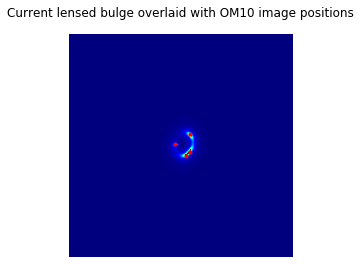

In [19]:
plt.matshow(orig_bulge_img_arr.T, extent=[-num_pix*0.5*pixel_scale, num_pix*0.5*pixel_scale, -num_pix*0.5*pixel_scale, num_pix*0.5*pixel_scale], origin='lower', cmap='jet')
plt.plot(om10_x_image[:n_image], om10_y_image[:n_image], 'r.')
plt.title('Current lensed bulge overlaid with OM10 image positions')
plt.axis('off')

(-5.0, 5.0, -5.0, 5.0)

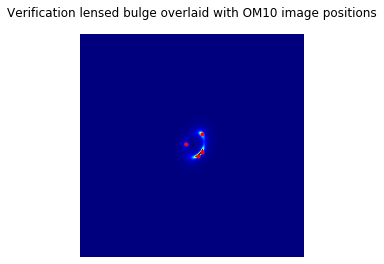

In [20]:
plt.matshow(bulge_img, extent=[-num_pix*0.5*pixel_scale, num_pix*0.5*pixel_scale, -num_pix*0.5*pixel_scale, num_pix*0.5*pixel_scale], origin='lower', cmap='jet')
plt.plot(om10_x_image[:n_image], om10_y_image[:n_image], 'r.')
plt.title('Verification lensed bulge overlaid with OM10 image positions')
plt.axis('off')

(-5.0, 5.0, -5.0, 5.0)

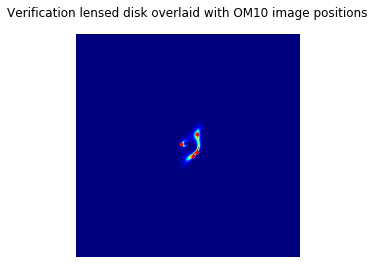

In [16]:
plt.matshow(disk_img, extent=[-num_pix*0.5*pixel_scale, num_pix*0.5*pixel_scale, -num_pix*0.5*pixel_scale, num_pix*0.5*pixel_scale], origin='lower', cmap='jet')
plt.plot(om10_x_image[:n_image], om10_y_image[:n_image], 'r.')
plt.title('Verification lensed disk overlaid with OM10 image positions')
plt.axis('off')

In [36]:
bulge_img[crop_pix:-crop_pix,crop_pix:-crop_pix].shape, num_pix - 2*crop_pix

((200, 200), 200)

In [50]:
om10_x_image/pixel_scale, om10_y_image/pixel_scale

(array([ 26.1 ,  43.21, -27.06,  43.33]),
 array([-47.24, -29.46,   3.26,  50.51]))

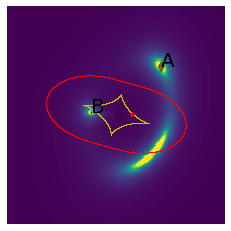

In [53]:
fig, ax = plt.subplots()
crop_pix = 400
eff_num_pix = num_pix - 2*crop_pix
x_source = all_kwargs['src_light']['center_x']
y_source = all_kwargs['src_light']['center_y']
ax = utils.lens_model_plot_custom(bulge_img[crop_pix:-crop_pix,crop_pix:-crop_pix], ax, lensModel=lens_mass_model, kwargs_lens=[all_kwargs['lens_mass'], all_kwargs['external_shear']], sourcePos_x=x_source, sourcePos_y=y_source, point_source=True, with_caustics=True, deltaPix=pixel_scale, numPix=eff_num_pix)

ax.plot(om10_x_image/pixel_scale + eff_num_pix*pixel_scale*0.5, om10_y_image/pixel_scale + eff_num_pix*pixel_scale*0.5, color='green', marker='*')

ax.axis('off')
fig.savefig('{:d}.png'.format(sys_id))

A more precise comparison would involve raytracing to get floating-point values of the image positions. To do so, we add another component to the image: the AGN. Instead of rendering the image of the lensed AGN, we extract its features.

In [27]:
components_with_agn = ['lens_mass', 'external_shear', 'src_light', 'agn_light']
bulge_or_disk = 'bulge' # back to bulge
all_kwargs['src_light'] = utils.get_src_light_params(src_light_info, bulge_or_disk=bulge_or_disk)
all_kwargs['agn_light'] = {'center_x': src_light_info['x_src'], 'center_y': src_light_info['y_src'], 'magnitude': 20.0} # exact magnitude value doesn't matter

from lenstronomy.PointSource.point_source import PointSource
ps_model = PointSource(point_source_type_list=['LENSED_POSITION'], fixed_magnification_list=[False])
#_, agn_img_features = generate_image_simple(all_kwargs, null_psf, data_api, lens_mass_model, src_light_model, lens_eq_solver, pixel_scale, num_pix, components_with_agn,  {'supersampling_factor': 1}, min_magnification=0.0, lens_light_model=None, ps_model=ps_model,)

x_image, y_image = lens_eq_solver.findBrightImage(src_light_info['x_src'], src_light_info['y_src'],
                                                 [all_kwargs['lens_mass'], all_kwargs['external_shear']],
                                                          min_distance=0.01, # default is 0.01
                                                          numImages=4,
                                                          search_window=num_pix*pixel_scale, # default is 5
                                                          precision_limit=10**(-10) # default,
                                                          ) 

Here are the verification image positions. (We sort images in the order of increasing dec, to enable consistent identification of images between OM10 and Lenstronomy.)

In [29]:
x_image = agn_img_features['x_image']
y_image = agn_img_features['y_image']
increasing_dec_i = np.argsort(y_image)
x_image = x_image[increasing_dec_i]
y_image = y_image[increasing_dec_i]
print(x_image, y_image)

[-0.23059416  0.41244925] [0.02560968 0.44880887]


Comparing with the OM10 image positions,

In [19]:
om10_increasing_dec_i = np.argsort(om10_y_image)
om10_x_image = np.array(om10_x_image)[om10_increasing_dec_i]
om10_y_image = np.array(om10_y_image)[om10_increasing_dec_i]
print(om10_x_image, om10_y_image)

[ 0.261   0.4321 -0.2706  0.4333] [-0.4724 -0.2946  0.0326  0.5051]


We can see that the image positions agree within ~6 mas, which is subpixel in this super-resolution setting.

In [43]:
print(np.linalg.norm(x_image - om10_x_image))
print(np.linalg.norm(y_image - om10_y_image))

ValueError: operands could not be broadcast together with shapes (4,) (2,) 

# 4. Time delays

The differences in the convergence profile and image positions manifest themselves in different time delays.

In [30]:
kwargs_model = {}
kwargs_model['lens_model_list'] = ['SIE', 'SHEAR_GAMMA_PSI']
kwargs_model['point_source_model_list'] = ['SOURCE_POSITION']
td_cosmo = TDCosmography(z_lens, z_src, kwargs_model, cosmo_fiducial=om10_cosmo)

In [31]:
ps_kwargs = [{'ra_source': src_light_info['x_src'], 'dec_source': src_light_info['y_src']}]
arrival_times = td_cosmo.time_delays([all_kwargs['lens_mass'], all_kwargs['external_shear']], ps_kwargs, kappa_ext=0.0)
arrival_times = arrival_times[increasing_dec_i]

In [32]:
om10_td = np.array(om10_df['time_delays'])[om10_increasing_dec_i]
om10_td = om10_td[1:] - om10_td[0]
print(om10_td)

[  0.737  47.508 -22.931]


In [33]:
td = arrival_times[1:] - arrival_times[0]
print(td)

[-61.30164475]


The time delay is accurate to ~1 day.

In [ ]:
td_err = td - np.array(om10_td)
td_err_frac = td_err/om10_td
print(td_err, td_err_frac)

# Other miscellaneous tests

## The lambda factor

We gather model parameters for the lens mass and source light.

OM10 and Lenstronomy have slightly different definitions of the SIE profile. In particular, OM10 scales the Einstein radius by the dynamical normalization parameter $\lambda(e)$, which takes into account the 3D shape of the lens galaxy.

In [ ]:
from scipy.interpolate import interp1d
def get_lambda_factor(ellip):
    """Get the interpolated lambda factor for the given Einstein radius that accounts for the ellipticity of projected mass

    Note
    ----
    The input data `ell_lef.dat` and this function are the work of Nan Li, based on Chae 2003

    Parameters
    ----------
    ellip : float
        the axis ratio defined as one minus minor/major axis

    Returns
    -------
    float
        the lambda factor with which to scale theta_E

    """
    e_tmp, lef_tmp = np.loadtxt("ell_lef.dat", comments='#', usecols=(0,1), unpack=True)
    interpolated_lambdas = interp1d(e_tmp, lef_tmp, kind='linear')
    return interpolated_lambdas(ellip)

In [ ]:
ellip_grid = np.linspace(1.e-5, 0.6, 100)
lambdas = np.array([get_lambda_factor(e) for e in ellip_grid])
plt.plot(ellip_grid, lambdas**2.0)
plt.ylabel('$\lambda^2$')
plt.xlabel('$e$')

![Lambda factor](chae_2003.png)

## Convergence map of Lenstronomy SIE

In [ ]:
from lenstronomy.Util import util
x, y = util.make_grid(numPix=num_pix, deltapix=pixel_scale)
kappa = lens_mass_model.kappa(x, y, [all_kwargs['lens_mass'], all_kwargs['external_shear']])
plt.imshow(np.log(util.array2image(kappa)))